In [320]:
import igraph 
from igraph import* 
import csv
from geopy.distance import geodesic 
import time;

#-.-.-.-.-.-.-OBTENER ESTACIONES (vertices del grafo) DE CSV-.-.-.-.-.-.-

In [321]:
heuristica={}

In [322]:
with open('estaciones.csv', mode='r') as file:
    # Crea un lector CSV
    reader = csv.reader(file)
    
    # Salta la primera fila que contiene los encabezados
    next(reader)
    
    # Inicializa una lista para almacenar los valores de la columna de estaciones
    nombre = []
    coordenada = {}
    # Itera a traves de las filas del archivo CSV
    for row in reader:
        # Agrega el valor de la columna "Estacion" a la lista
        nombre.append(row[1])
        x = (float)(row[3]) # Coordenadas X
        y = (float)(row[4]) # Coordenadas Y
        coordenada.update({row[1]:[x,y]})

#-.-.-.-.-.-.-OBTENER ARISTAS Y PESOS(conexiones entre estaciones) DE CSV-.-.-.-.-.-.-

In [323]:
with open('aristas.csv', mode='r') as file:
    # Crea un lector CSV
    reader = csv.reader(file)
    
    # Salta la primera fila que contiene los encabezados
    next(reader)
    
    # Inicializa una lista para almacenar las aristas y pesos
    aristas = []
    pesos = []

    # Itera a traves de las filas del archivo CSV
    for i, row in enumerate(reader):
        for j, valor in enumerate(row[1:]):  # Empezamos desde la columna 1 para omitir la primera columna
            if( i<= j): # Si no se ha llegado aun a la diagonal principal (Queremos evitar aristas repetidas)
                if valor != "0":
                    pesos.append(float(valor))
                    aristas.append((i, j))

In [324]:
def calculoHeuristica(destino):
    destinoX = coordenada.get(destino)[0]
    destinoY = coordenada.get(destino)[1]
    for origen in coordenada:
        origenX = coordenada.get(origen)[0]
        origenY = coordenada.get(origen)[1]
        distanciaLineaRecta = geodesic((destinoX,destinoY),(origenX,origenY)).km
        heuristica.update({origen:distanciaLineaRecta})


#-.-.-.-.-.-.-PREPARAR GRAFO-.-.-.-.-.-.-

In [325]:
n_vertices = 40
print(aristas)
grafo = igraph.Graph(n_vertices, aristas)   # Creamos grafo
grafo["title"] = "Metro de Lyon" # Titulo del grafo
grafo.vs["name"] = nombre   # Nombre de los nodos
grafo.es["pesos"] = pesos   # Pesos de las arista
grafo.vs["color"] = ['red','red','red','red','red','red','red', 'red','red','red','red','red','red','red','red', 'red', 'red','red','red','red','red','red','red', 'red', 'red','red','red','red','red','red','red', 'red', 'red','red','red','red','red','red','red', 'red', 'red','red','red','red','red','red','red', 'red']
grafo.vs["label"] = nombre
grafo.vs["size"] = 70
#print(grafo.vs["name"])
#print(grafo)

[(0, 1), (1, 2), (2, 3), (2, 30), (2, 31), (3, 4), (4, 5), (4, 26), (5, 6), (6, 7), (7, 8), (7, 14), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (14, 15), (15, 16), (16, 17), (17, 18), (17, 31), (17, 32), (18, 19), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (25, 26), (27, 28), (28, 29), (29, 30), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39)]


#-.-.-.-.-.-.-ALGORITMO ASTAR-.-.-.-.-.-.-

In [326]:
class Nodo:     
    def __init__(self, estacion, g = 0, h = 0):  
        self.estacion = estacion     #el propio nodo
        self.padre = None          #nodo padre
        self.g = g                 #valor g
        self.h = h                 #valor h
        self.f = 0                 #valor f
  

In [327]:
def algoritmoAStar(Inicio,Destino):
   # inicialización de variable
   estacioInicio = grafo.vs.find(Inicio)
   estacionDestino = grafo.vs.find(Destino)
   coste = 0
   calculoHeuristica(estacionDestino["name"])
   listaNodoAbierto = {}
   listaNodoCerrado = {}
   ruta = []
   nodoInicio = Nodo(estacioInicio)
   nodoDestino = Nodo(estacionDestino)
   nodoActual = nodoInicio
   listaNodoAbierto.update({estacioInicio["name"]:nodoActual})
   
   while(listaNodoAbierto):
      # seleccionar el nodo con f menor y elimian de la lista abierto añadir en la lista cerrado
      nodoActual = getNodoMinimo(listaNodoAbierto)
      listaNodoCerrado.update({nodoActual.estacion["name"]:nodoActual})
      del listaNodoAbierto[nodoActual.estacion["name"]]
      explorarVecino(grafo,heuristica,listaNodoAbierto,listaNodoCerrado,nodoActual)
      nodo = hayDestinoEnListaNodoAbierto(listaNodoAbierto,estacionDestino)
      
      while nodo != None:
         ruta.append(nodo.estacion["name"])
         indice_nodo = grafo.vs.find(name=(nodo.estacion["name"])).index
         grafo.vs[indice_nodo]["color"] = 'green'
         if nodo.padre != None:
            indiceArista = grafo.get_eid(nodo.estacion,nodo.padre.estacion)
            grafo.es[indiceArista]["width"] = 3.0
         coste = coste + nodo.g
         nodo = nodo.padre
         listaNodoAbierto={}
   
   for estacion in reversed(ruta):
      print(estacion)
   print("coste de distancia es {:.1f}km".format(coste))

In [328]:
def hayDestinoEnListaNodoAbierto(listaNodoAbierto,estacionDestino):
    for estacion in listaNodoAbierto:
        nodo = listaNodoAbierto.get(estacion)
        if nodo.estacion == estacionDestino:
            return nodo
    return None

In [329]:
#metodo que devuelve un nodo con f menor en la lista de nodo abierto 
def getNodoMinimo(listaNodoAbierto):
    menor = 11111111111
    for estacion in listaNodoAbierto:
        nodo = listaNodoAbierto.get(estacion)  
        if nodo.f < menor:  
            nodoMenor = nodo
            menor =  nodo.f 
        return nodoMenor

In [330]:
#exploral todos los nodos vecino de nodo actual y calcuar la f 
def explorarVecino(grafo:igraph,heuristica,listaNodoAbierto,listaNodoCerrado,nodoActual):
    verticeVecino = nodoActual.estacion.neighbors()
    for estacion in verticeVecino:
      
        if estacion["name"] in listaNodoCerrado:
            continue
        nodo = Nodo(estacion)
        indiceArista = grafo.get_eid(nodoActual.estacion,estacion)
        peso = grafo.es[indiceArista]["pesos"]
        g = peso + nodoActual.g
        h = heuristica.get(estacion["name"])
        f = g+h
        nodo.g = g
        nodo.h = h
        nodo.f = f
        nodo.padre = nodoActual

        if estacion in listaNodoAbierto:
            nodoAux = listaNodoAbierto.get(estacion["name"])
            if nodo.f < nodoAux.f:
                listaNodoAbierto.update({estacion["name"]:nodo})
        else:
             listaNodoAbierto.update({estacion["name"]:nodo})

Gare de Venissieux
Parilly
Mermoz Pinel
Laennec
Grange Blanche
Monplaisir-Lumiere
Sans-Souci
Garibaldi
Saxe-Gambetta
Jean Macé
Place Jean Jaures
Debourg
Stade de Gerland
Oullins Gare
coste de distancia es 87.3km


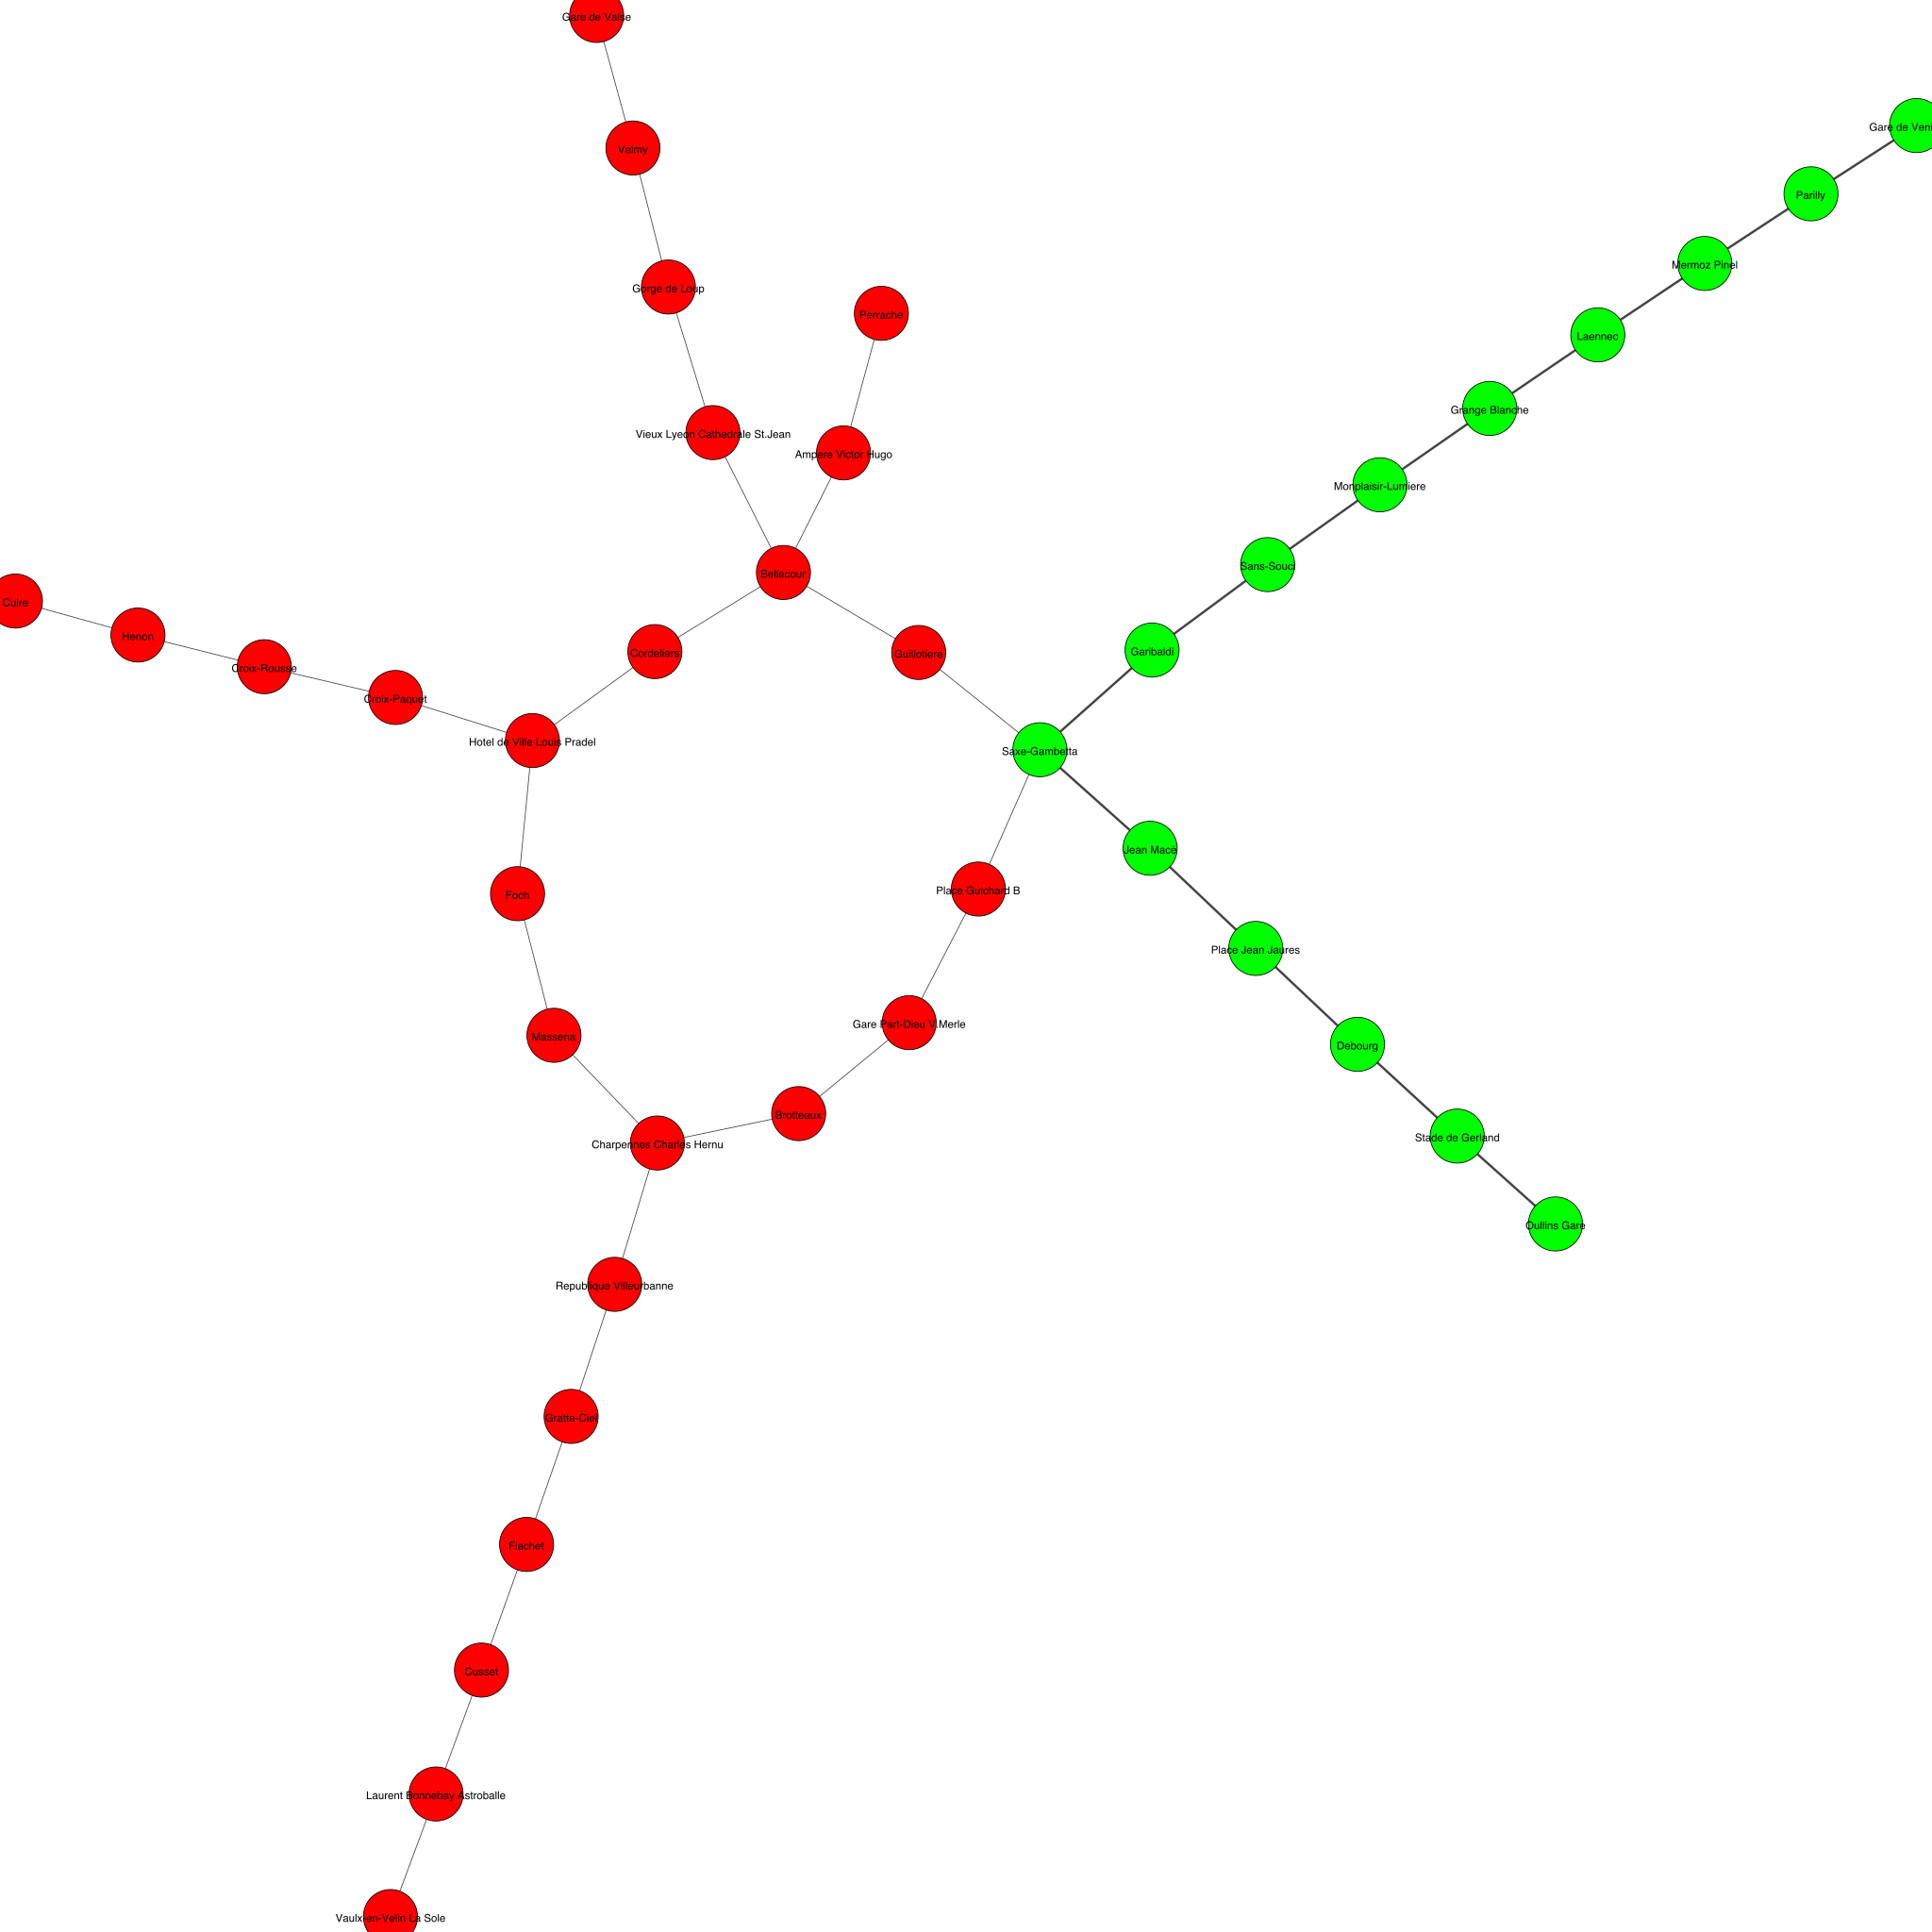

In [331]:
algoritmoAStar("Gare de Venissieux","Oullins Gare")
igraph.plot(grafo, bbox=(0, 0, 2500, 2500))
